In [32]:
import os
import sys
import pretty_midi
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from numpy.linalg import norm
from scipy.stats import entropy
from itertools import combinations


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utils import basename
from src.utils.midi import transpose_midi
from src.utils.constants import NOTE_NAMES
from src.ml.specdiff.model import SpectrogramDiffusion

In [34]:
np.random.seed(0)

# DATA_DIR = "/media/scratch/sageev-midi/20250410/augmented"
DATA_DIR = "/media/scratch/sageev-midi/teeny"
# temporary directory for transposed files
TMP_DIR = "/home/finlay/disklavier/tests/outputs/tmp"
os.makedirs(TMP_DIR, exist_ok=True)

model = SpectrogramDiffusion(fix_time=False, verbose=False)

all_files = glob(os.path.join(DATA_DIR, "*.mid"))
# all_files = glob(os.path.join(DATA_DIR, "*_t00s00.mid"))
all_files.sort()

chosen_file = np.random.choice(all_files, size=1)[0]

all_results = []
chosen_file

04-20 09:39:49.991095 spcdif: initializing spectrogram diffusion model                                  ]8;id=768814;file:///home/finlay/disklavier/src/ml/specdiff/model.py\model.py]8;;\:]8;id=279313;file:///home/finlay/disklavier/src/ml/specdiff/model.py#53\53]8;;\

04-20 09:39:51.308931 spcdif: model initialization complete                                             ]8;id=38803;file:///home/finlay/disklavier/src/ml/specdiff/model.py\model.py]8;;\:]8;id=743785;file:///home/finlay/disklavier/src/ml/specdiff/model.py#79\79]8;;\

'/media/scratch/sageev-midi/teeny/half_47_c4.mid'

In [35]:
midi = pretty_midi.PrettyMIDI(chosen_file)
base_embedding = model.embed(chosen_file).squeeze().flatten()

lowest_note_og = min(
    note.pitch for instrument in midi.instruments for note in instrument.notes
)
highest_note_og = max(
    note.pitch for instrument in midi.instruments for note in instrument.notes
)

for instrument in midi.instruments:
    for note in instrument.notes:
        note.pitch -= lowest_note_og - 12

lowest_note_new = min(
    note.pitch for instrument in midi.instruments for note in instrument.notes
)
print(f"{lowest_note_og} -> {lowest_note_new}")
highest_note_new = max(
    note.pitch for instrument in midi.instruments for note in instrument.notes
)
print(f"{highest_note_og} -> {highest_note_new}")

72 -> 12
76 -> 16


In [36]:
file_data = {}
transpositions = []
transposition = -(lowest_note_og - 12)
while highest_note_new < 109:
    new_id = basename(chosen_file)
    new_id = new_id + f"_o{transposition}.mid"
    tmp_path = os.path.join(TMP_DIR, new_id)
    transpose_midi(chosen_file, tmp_path, transposition)

    transposed_embedding = model.embed(tmp_path).squeeze().flatten()
    diff_vector = transposed_embedding - base_embedding
    magnitude_diff = norm(diff_vector)

    norm_base = norm(base_embedding)
    norm_transposed = norm(transposed_embedding)
    cosine_sim = np.dot(base_embedding, transposed_embedding) / (
        norm_base * norm_transposed
    )
    cosine_sim = np.clip(cosine_sim, -1.0, 1.0)

    file_data[new_id] = {
        "path": tmp_path,
        "pr": pretty_midi.PrettyMIDI(tmp_path).get_piano_roll(10),
        # "embedding": specdiff.embed(tmp_path),
        "mag": magnitude_diff,
        "cos": cosine_sim,
        "transposition": transposition,
    }

    for instrument in midi.instruments:
        for note in instrument.notes:
            note.pitch += 1
    highest_note_new = max(
        note.pitch for instrument in midi.instruments for note in instrument.notes
    )
    transpositions.append(transposition)
    transposition += 1

In [37]:
all_prs = []
for k, v in file_data.items():
    all_prs.append(v["pr"])
all_prs = np.hstack(all_prs)
all_prs.shape

(128, 1860)

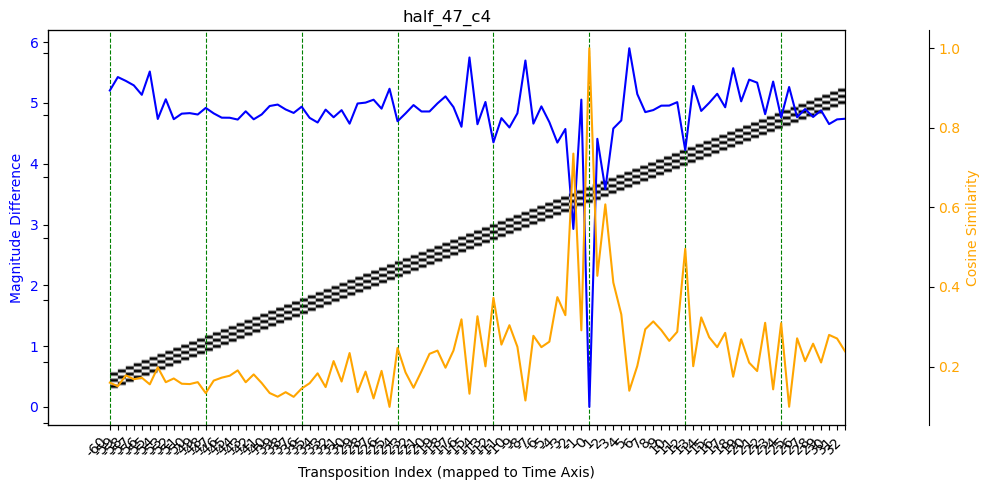

In [38]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# plot the piano roll on the primary axis
im = ax1.imshow(all_prs, cmap="gray_r", aspect="auto", origin="lower")
ax1.set_xlabel("Time")
ax1.set_ylabel("Pitch")
ax1.set_title(basename(chosen_file))

# extract data for line plots
transposition_values = [v["transposition"] for v in file_data.values()]
mag_values = [v["mag"] for v in file_data.values()]
cos_values = [v["cos"] for v in file_data.values()]

# create secondary axes for magnitude (left)
ax2 = ax1.twinx()
ax2.plot(transposition_values, mag_values, color="blue", label="Magnitude Diff")
ax2.set_ylabel("Magnitude Difference", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
# adjust y-axis position for magnitude to the left
ax2.yaxis.set_label_position("left")
ax2.yaxis.tick_left()


# create tertiary axes for cosine similarity (right)
ax3 = ax1.twinx()
ax3.plot(transposition_values, cos_values, color="orange", label="Cosine Similarity")
ax3.set_ylabel("Cosine Similarity", color="orange")
ax3.tick_params(axis="y", labelcolor="orange")
# ensure the right spine is visible and used for the ticks
ax3.spines["right"].set_position(("outward", 60))  # offset the right spine
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()


# set x-axis label using the primary axis
# map transposition values to the corresponding time steps in the imshow plot if necessary
# for simplicity, let's assume the transposition index corresponds to the x-axis for the line plots
# If the 'Time' axis of imshow relates differently, this mapping needs adjustment.
# We will plot against the index of transposition for now.
num_transpositions = len(transposition_values)
x_ticks_positions = np.linspace(
    0, all_prs.shape[1] - 1, num=num_transpositions
)  # map transposition indices to time axis

# clear previous plots on ax2 and ax3 if they were plotted against indices
ax2.lines[0].remove()
ax3.lines[0].remove()

# plot again using the correct x-axis mapping
ax2.plot(x_ticks_positions, mag_values, color="blue")
ax3.plot(x_ticks_positions, cos_values, color="orange")

# hide the original pitch y-axis labels as they are overridden
ax1.yaxis.set_ticklabels([])
ax1.set_ylabel("")  # remove label as well if desired

# set x-axis label and ticks related to transposition
ax1.set_xlabel("Transposition Index (mapped to Time Axis)")
ax1.set_xticks(x_ticks_positions)
# Use transposition values as tick labels, rotating for clarity
ax1.set_xticklabels(transposition_values, rotation=45, ha="right")

for i, t_val in enumerate(transposition_values):
    if t_val % 12 == 0:
        ax1.axvline(
            x_ticks_positions[i],
            color="green",
            linestyle="--",
            linewidth=0.8,
            ymin=0,
            ymax=1,
        )

plt.tight_layout()  # adjust layout to prevent overlap
plt.show()